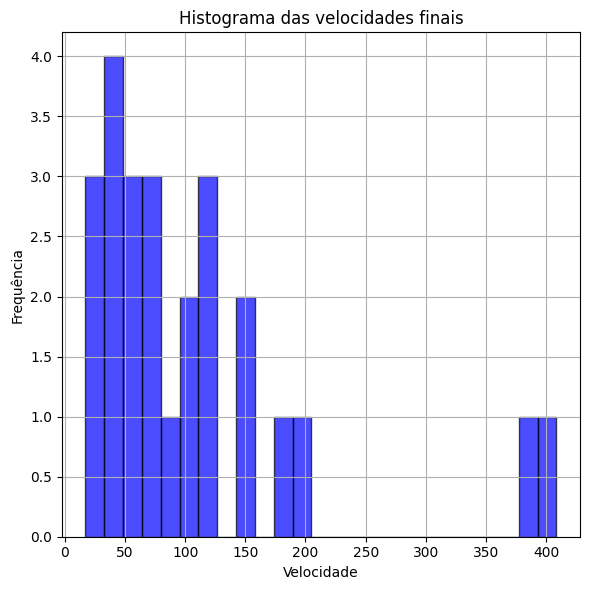

SystemExit: 

C:\venv\ilumpy-VS\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
#Debugging 21-09-2023
#UI == pygame
#Implementado gráfico Max-Boltz
#Testar colisão por grid
#Colisões e previsão funcionam + grid (inherited 6.10)
#Colisão inelástica e elástica implementada
#Fazer: adaptar colisões para classe (talvez?)


import math
import random
import warnings
import pygame
from pygame.locals import *
from sys import exit
import numpy as np
import matplotlib.pyplot as plt

# Constants
FPS = 60
dt = 1/FPS
altura_caixa = 500
largura_caixa = 500
num_particulas = 25
grid_size = 10
future_factor = 2
tipo_colisao = 'elastic'
C = 0.8 #coeficiente de restituição

# Colors
WHITE = (255, 255, 255)

class Particula:
    def __init__(self, massa, raio, vel_x, vel_y, x, y, x_future, y_future, cor):
        self.massa = float(massa)
        self.raio = float(raio)
        self.vel_x = float(vel_x)
        self.vel_y = float(vel_y)
        self.x = float(x)
        self.y = float(y)
        self.x_future = float(x_future)
        self.y_future = float(y_future)
        self.cor = cor

    def deslocar(self):

        self.x += self.vel_x * dt
        self.y += self.vel_y * dt

        # Colisao parede
        if self.x < self.raio or self.x > largura_caixa - self.raio:
            self.vel_x *= -1
        if self.y < self.raio or self.y > altura_caixa - self.raio:
            self.vel_y *= -1

    def next_position(self, dt, future_factor):
        self.x_future = self.x + self.vel_x * dt * future_factor
        self.y_future = self.y + self.vel_y * dt * future_factor

class Grid:
    def __init__(self, width, height, cell_size):
        self.width = width
        self.height = height
        self.cell_size = cell_size
        self.num_cols = int(width / cell_size)
        self.num_rows = int(height / cell_size)
        self.grid = [[] for _ in range(self.num_cols * self.num_rows)] #cria uma grid nova

    def clear(self):
        self.grid = [[] for _ in range(self.num_cols * self.num_rows)] #'limpa' a grid

    def index(self, x, y):
        col = int(x / self.cell_size)
        row = int(y / self.cell_size)
        
        # Ensure col and row are within bounds
        col = max(0, min(col, self.num_cols - 1))
        row = max(0, min(row, self.num_rows - 1))
        
        return col + row * self.num_cols

    def insert(self, particle):
        index = self.index(particle.x, particle.y)
        self.grid[index].append(particle)

    def get_particles_in_cell(self, x, y):
        index = self.index(x, y)
        return self.grid[index]

    def update_grid(self, particles):
        self.clear()
        for particle in particles.values():
            self.insert(particle)

    def check_grid_collision(self, particles, grid):
        for particle in particles.values():
            cell_x = int(particle.x / grid.cell_size)
            cell_y = int(particle.y / grid.cell_size)

            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    neighbor_x = cell_x + dx
                    neighbor_y = cell_y + dy
                    if 0 <= neighbor_x < grid.num_cols and 0 <= neighbor_y < grid.num_rows:
                        for neighbor in grid.get_particles_in_cell(neighbor_x * grid.cell_size, neighbor_y * grid.cell_size):
                            if particle != neighbor and check_collision(particle, neighbor):
                                #print(f"Collision detected between {particle} and {neighbor}")
                                resolve_collision(particle, neighbor, collision_type=tipo_colisao)

def check_collision(p1, p2):

    p1.next_position(dt, future_factor) #proxima_posicao

    p2.next_position(dt, future_factor) #proxima_posicao

    distance_future = math.sqrt((p2.x_future - p1.x_future)**2 + (p2.y_future - p1.y_future)**2)
    distance = math.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)
    if ((distance <= p1.raio + p2.raio) or (distance_future <= p1.raio + p2.raio)) == True:
        return True
    else:
        return False


def resolve_collision(p1, p2, collision_type='elastic'):
    x1 = np.array([p1.x, p1.y])
    x2 = np.array([p2.x, p2.y])

    #print('arrays_x:', x1, x2)

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    #print('arrays_v:', v1, v2)

    if collision_type == 'elastic' or collision_type == 'elastica':
        #print('elastica')

        new_v1 = v1 - (((2 * p2.massa) / (p1.massa + p2.massa)) * ((np.dot((v1 - v2), (x1 - x2))) / ((np.linalg.norm(x1 - x2))**2)) * (x1 - x2))
        new_v2 = v2 - (((2 * p1.massa) / (p1.massa + p2.massa)) * ((np.dot((v2 - v1), (x2 - x1))) / ((np.linalg.norm(x2 - x1))**2)) * (x2 - x1))


    if collision_type == 'inelastic' or collision_type == 'inelastica':
        #print('inelastica')

        new_v1 = v1 - ((((C * p2.massa) + p2.massa) / (p1.massa + p2.massa)) * ((np.dot((v1 - v2),(x1 - x2))) / ((np.linalg.norm(x1 - x2))**2)) * (x1 - x2))
        new_v2 = v2 - ((((C * p1.massa) + p1.massa) / (p1.massa + p2.massa)) * ((np.dot((v2 - v1),(x2 - x1))) / ((np.linalg.norm(x2 - x1))**2)) * (x2 - x1))

    p1.vel_x = new_v1[0]
    p1.vel_y = new_v1[1]
    p2.vel_x = new_v2[0]
    p2.vel_y = new_v2[1]

    #print(p1.vel_x, p1.vel_y, p2.vel_x, p2.vel_y)

#src_elastica = https://en.wikipedia.org/wiki/Elastic_collision#Two-dimensional_collision_with_two_moving_objects
#src_inelastica = https://physics.stackexchange.com/questions/708495/angle-free-two-dimensional-inelastic-collision-formula


def gerar_particula(n_particulas, largura_caixa, altura_caixa):
    particulas = {}

    #atomos
    atomos = {
        "Na": {"massa": 22, "raio": 22, "color": (255, 0, 0)},
        "Cl": {"massa": 35, "raio": 35, "color": (0, 255, 0)},
        "H": {"massa": 1, "raio": 1, "color": (0, 0, 255)},
        "O":{"massa": 16, "raio": 16, "color": (225, 225, 0)}
    }

    for particle_index in range(1, n_particulas + 1):
        #escolha de distribuição aleatória
        atomos_selecionar = random.choice(list(atomos.keys()))

        attributes = atomos[atomos_selecionar]
        
        massa = attributes["massa"]
        raio = attributes["raio"]
        vel_x = random.uniform(-100, 100) #velocidade inicial não especificada
        vel_y = random.uniform(-100, 100)
        x = random.uniform(raio, largura_caixa - raio)
        y = random.uniform(raio, altura_caixa - raio)
        x_future = x + vel_x * dt * future_factor
        y_future = y + vel_y * dt * future_factor
        cor = attributes["color"]
        nome_particula = f"{atomos_selecionar}_{particle_index}" 
        particle_instance = Particula(massa, raio, vel_x, vel_y, x, y, x_future, y_future, cor)
        particulas[nome_particula] = particle_instance

    return particulas


def intersection_pos_checker(particles,iteration_max = 100):
    iteration_count = 0
    intersection = False
    for particle_name, particle_instance in particles.items():
        for other_particle_name, other_particle_instance in particles.items():
            if particle_name != other_particle_name and check_collision(particle_instance, other_particle_instance):
                particle_move = random.choice([[particle_name,particle_instance], [other_particle_name,other_particle_instance]])
                new_x = random.uniform(particle_move[1].raio, largura_caixa - (particle_move[1].raio))
                new_y = random.uniform(particle_move[1].raio, altura_caixa - (particle_move[1].raio))
                particles[particle_move[0]].x = new_x
                particles[particle_move[0]].y = new_y
                iteration_count +=1
                #print(particles[particle_move[0]].y) #verificar coordenadas alteradas

                intersection = True
                if iteration_max == iteration_count:
                    warnings.warn(f'{iteration_max} iterações atingidas. Deve haver partículas sobrepostas. Altere o tamanho da caixa.')
                    return particles
    
    if intersection == True:
        #print('True')
        return intersection_pos_checker(particles)

    if intersection == False:
        #print('False')
        return particles

def create_particle_sprites(particles):
    sprites = pygame.sprite.Group()
    for particle_instance in particles.values():
        circle = pygame.Surface((particle_instance.raio * 2, particle_instance.raio * 2), pygame.SRCALPHA)
        pygame.draw.circle(circle, particle_instance.cor, (particle_instance.raio, particle_instance.raio), particle_instance.raio)
        sprite = pygame.sprite.Sprite()
        sprite.image = circle
        sprite.rect = sprite.image.get_rect(center=(particle_instance.x, particle_instance.y))
        sprites.add(sprite)
    return sprites

def main():
    final_speeds = []
    pygame.init()
    screen = pygame.display.set_mode((largura_caixa, altura_caixa))
    pygame.display.set_caption("Collision Simulation")

    particles = gerar_particula(num_particulas, largura_caixa, altura_caixa)
    particles = intersection_pos_checker(particles)
    sprites = create_particle_sprites(particles)

    grid = Grid(largura_caixa, altura_caixa, grid_size)

    clock = pygame.time.Clock()

    while True:
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                # Pegar velocidades finais de todas as particulas
                for particle_instance in particles.values():
                    final_speed = math.sqrt(particle_instance.vel_x**2 + particle_instance.vel_y**2)
                    final_speeds.append(final_speed)

                # Barplot/histograma das velocidades Max-Boltz.
                fig, ax = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
                plt.hist(final_speeds, bins=25, color='blue', edgecolor='black', alpha=0.7)
                plt.xlabel('Velocidade')
                plt.ylabel('Frequência')
                plt.title('Histograma das velocidades finais')
                plt.grid(True)
                fig.tight_layout()
                fig.savefig("max-boltz_6_8_1.png")  # Salva a figura

                plt.show()
                exit()

        # Update the grid with the new particle positions
        grid.update_grid(particles)

        # Check for collisions based on the updated grid
        grid.check_grid_collision(particles, grid)

        # Resolve collisions after updating positions
        for particle_name, particle_instance in particles.items():
            for other_particle_name, other_particle_instance in particles.items():
                if particle_name != other_particle_name and check_collision(particle_instance, other_particle_instance):
                    #print(f"Collision detected between {particle_name} and {other_particle_name}")
                    resolve_collision(particle_instance, other_particle_instance, collision_type=tipo_colisao)

        # Update particle positions after collision detection
        for particle_name, particle_instance in particles.items():
            particle_instance.deslocar()

        # Update sprite positions
        for sprite, particle_instance in zip(sprites, particles.values()):
            sprite.rect.center = (particle_instance.x, particle_instance.y)

        screen.fill(WHITE)
        sprites.draw(screen)

        pygame.display.flip()
        clock.tick(FPS)

if __name__ == "__main__":
    main()



future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future foreseed
future f

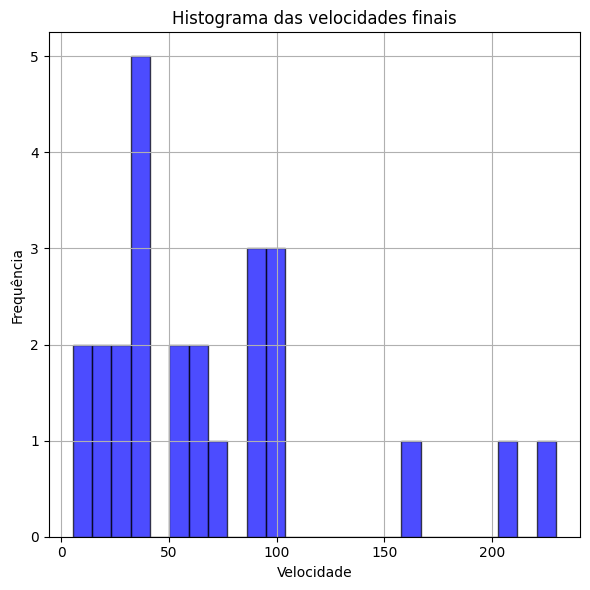

SystemExit: 

C:\venv\ilumpy-VS\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
#Debugging 21-09-2023
#UI == pygame
#Implementado gráfico Max-Boltz
#Testar colisão por grid
#Colisões e previsão funcionam + grid (inherited 6.10)
#Colisão inelástica e elástica implementada
#Fazer: adaptar colisões para classe (talvez?)


import math
import random
import warnings
import pygame
from pygame.locals import *
from sys import exit
import numpy as np
import matplotlib.pyplot as plt

# Constants
FPS = 60
dt = 1/FPS
altura_caixa = 500
largura_caixa = 500
num_particulas = 25
grid_size = 10
future_factor = 2
tipo_colisao = 'elastic'
C = 0.8 #coeficiente de restituição

# Colors
WHITE = (255, 255, 255)

class Particula:
    def __init__(self, massa, raio, vel_x, vel_y, x, y, x_future, y_future, cor):
        self.massa = float(massa)
        self.raio = float(raio)
        self.vel_x = float(vel_x)
        self.vel_y = float(vel_y)
        self.x = float(x)
        self.y = float(y)
        self.x_future = float(x_future)
        self.y_future = float(y_future)
        self.cor = cor

    def deslocar(self):

        self.x += self.vel_x * dt
        self.y += self.vel_y * dt

        # Colisao parede
        if self.x < self.raio or self.x > largura_caixa - self.raio:
            self.vel_x *= -1
        if self.y < self.raio or self.y > altura_caixa - self.raio:
            self.vel_y *= -1

    def next_position(self, dt, future_factor):
        self.x_future = self.x + self.vel_x * dt * future_factor
        self.y_future = self.y + self.vel_y * dt * future_factor

class Grid:
    def __init__(self, width, height, cell_size):
        self.width = width
        self.height = height
        self.cell_size = cell_size
        self.num_cols = int(width / cell_size)
        self.num_rows = int(height / cell_size)
        self.grid = [[] for _ in range(self.num_cols * self.num_rows)] #cria uma grid nova

    def clear(self):
        self.grid = [[] for _ in range(self.num_cols * self.num_rows)] #'limpa' a grid

    def index(self, x, y):
        col = int(x / self.cell_size)
        row = int(y / self.cell_size)
        
        # Ensure col and row are within bounds
        col = max(0, min(col, self.num_cols - 1))
        row = max(0, min(row, self.num_rows - 1))
        
        return col + row * self.num_cols

    def insert(self, particle):
        index = self.index(particle.x, particle.y)
        self.grid[index].append(particle)

    def get_particles_in_cell(self, x, y):
        index = self.index(x, y)
        return self.grid[index]

    def update_grid(self, particles):
        self.clear()
        for particle in particles.values():
            self.insert(particle)

    def check_grid_collision(self, particles, grid):
        for particle in particles.values():
            cell_x = int(particle.x / grid.cell_size)
            cell_y = int(particle.y / grid.cell_size)

            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    neighbor_x = cell_x + dx
                    neighbor_y = cell_y + dy
                    if 0 <= neighbor_x < grid.num_cols and 0 <= neighbor_y < grid.num_rows:
                        for neighbor in grid.get_particles_in_cell(neighbor_x * grid.cell_size, neighbor_y * grid.cell_size):
                            if particle != neighbor and check_collision(particle, neighbor):
                                #print(f"Collision detected between {particle} and {neighbor}")
                                resolve_collision(particle, neighbor, collision_type=tipo_colisao)

def check_collision(p1, p2):

    p1.next_position(dt, future_factor) #proxima_posicao

    p2.next_position(dt, future_factor) #proxima_posicao

    distance_future = math.sqrt((p2.x_future - p1.x_future)**2 + (p2.y_future - p1.y_future)**2)
    distance = math.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)
    if ((distance_future <= p1.raio + p2.raio)) == True:
        print('future foreseed')
        return True
    else:
        return False


def resolve_collision(p1, p2, collision_type='elastic'):
    x1 = np.array([p1.x, p1.y])
    x2 = np.array([p2.x, p2.y])

    #print('arrays_x:', x1, x2)

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    #print('arrays_v:', v1, v2)

    if collision_type == 'elastic' or collision_type == 'elastica':
        #print('elastica')

        new_v1 = v1 - (((2 * p2.massa) / (p1.massa + p2.massa)) * ((np.dot((v1 - v2), (x1 - x2))) / ((np.linalg.norm(x1 - x2))**2)) * (x1 - x2))
        new_v2 = v2 - (((2 * p1.massa) / (p1.massa + p2.massa)) * ((np.dot((v2 - v1), (x2 - x1))) / ((np.linalg.norm(x2 - x1))**2)) * (x2 - x1))


    if collision_type == 'inelastic' or collision_type == 'inelastica':
        #print('inelastica')

        new_v1 = v1 - ((((C * p2.massa) + p2.massa) / (p1.massa + p2.massa)) * ((np.dot((v1 - v2),(x1 - x2))) / ((np.linalg.norm(x1 - x2))**2)) * (x1 - x2))
        new_v2 = v2 - ((((C * p1.massa) + p1.massa) / (p1.massa + p2.massa)) * ((np.dot((v2 - v1),(x2 - x1))) / ((np.linalg.norm(x2 - x1))**2)) * (x2 - x1))

    p1.vel_x = new_v1[0]
    p1.vel_y = new_v1[1]
    p2.vel_x = new_v2[0]
    p2.vel_y = new_v2[1]

    #print(p1.vel_x, p1.vel_y, p2.vel_x, p2.vel_y)

#src_elastica = https://en.wikipedia.org/wiki/Elastic_collision#Two-dimensional_collision_with_two_moving_objects
#src_inelastica = https://physics.stackexchange.com/questions/708495/angle-free-two-dimensional-inelastic-collision-formula


def gerar_particula(n_particulas, largura_caixa, altura_caixa):
    particulas = {}

    #atomos
    atomos = {
        "Na": {"massa": 22, "raio": 22, "color": (255, 0, 0)},
        "Cl": {"massa": 35, "raio": 35, "color": (0, 255, 0)},
        "H": {"massa": 1, "raio": 1, "color": (0, 0, 255)},
        "O":{"massa": 16, "raio": 16, "color": (225, 225, 0)}
    }

    for particle_index in range(1, n_particulas + 1):
        #escolha de distribuição aleatória
        atomos_selecionar = random.choice(list(atomos.keys()))

        attributes = atomos[atomos_selecionar]
        
        massa = attributes["massa"]
        raio = attributes["raio"]
        vel_x = random.uniform(-100, 100) #velocidade inicial não especificada
        vel_y = random.uniform(-100, 100)
        x = random.uniform(raio, largura_caixa - raio)
        y = random.uniform(raio, altura_caixa - raio)
        x_future = x + vel_x * dt * future_factor
        y_future = y + vel_y * dt * future_factor
        cor = attributes["color"]
        nome_particula = f"{atomos_selecionar}_{particle_index}" 
        particle_instance = Particula(massa, raio, vel_x, vel_y, x, y, x_future, y_future, cor)
        particulas[nome_particula] = particle_instance

    return particulas


def intersection_pos_checker(particles,iteration_max = 100):
    iteration_count = 0
    intersection = False
    for particle_name, particle_instance in particles.items():
        for other_particle_name, other_particle_instance in particles.items():
            if particle_name != other_particle_name and check_collision(particle_instance, other_particle_instance):
                particle_move = random.choice([[particle_name,particle_instance], [other_particle_name,other_particle_instance]])
                new_x = random.uniform(particle_move[1].raio, largura_caixa - (particle_move[1].raio))
                new_y = random.uniform(particle_move[1].raio, altura_caixa - (particle_move[1].raio))
                particles[particle_move[0]].x = new_x
                particles[particle_move[0]].y = new_y
                iteration_count +=1
                #print(particles[particle_move[0]].y) #verificar coordenadas alteradas

                intersection = True
                if iteration_max == iteration_count:
                    warnings.warn(f'{iteration_max} iterações atingidas. Deve haver partículas sobrepostas. Altere o tamanho da caixa.')
                    return particles
    
    if intersection == True:
        #print('True')
        return intersection_pos_checker(particles)

    if intersection == False:
        #print('False')
        return particles

def create_particle_sprites(particles):
    sprites = pygame.sprite.Group()
    for particle_instance in particles.values():
        circle = pygame.Surface((particle_instance.raio * 2, particle_instance.raio * 2), pygame.SRCALPHA)
        pygame.draw.circle(circle, particle_instance.cor, (particle_instance.raio, particle_instance.raio), particle_instance.raio)
        sprite = pygame.sprite.Sprite()
        sprite.image = circle
        sprite.rect = sprite.image.get_rect(center=(particle_instance.x, particle_instance.y))
        sprites.add(sprite)
    return sprites

def main():
    final_speeds = []
    pygame.init()
    screen = pygame.display.set_mode((largura_caixa, altura_caixa))
    pygame.display.set_caption("Collision Simulation")

    particles = gerar_particula(num_particulas, largura_caixa, altura_caixa)
    particles = intersection_pos_checker(particles)
    sprites = create_particle_sprites(particles)

    grid = Grid(largura_caixa, altura_caixa, grid_size)

    clock = pygame.time.Clock()

    while True:
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                # Pegar velocidades finais de todas as particulas
                for particle_instance in particles.values():
                    final_speed = math.sqrt(particle_instance.vel_x**2 + particle_instance.vel_y**2)
                    final_speeds.append(final_speed)

                # Barplot/histograma das velocidades Max-Boltz.
                fig, ax = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
                plt.hist(final_speeds, bins=25, color='blue', edgecolor='black', alpha=0.7)
                plt.xlabel('Velocidade')
                plt.ylabel('Frequência')
                plt.title('Histograma das velocidades finais')
                plt.grid(True)
                fig.tight_layout()
                fig.savefig("max-boltz_6_8_1.png")  # Salva a figura

                plt.show()
                exit()

        # Update the grid with the new particle positions
        grid.update_grid(particles)

        # Check for collisions based on the updated grid
        grid.check_grid_collision(particles, grid)

        # Resolve collisions after updating positions
        for particle_name, particle_instance in particles.items():
            for other_particle_name, other_particle_instance in particles.items():
                if particle_name != other_particle_name and check_collision(particle_instance, other_particle_instance):
                    #print(f"Collision detected between {particle_name} and {other_particle_name}")
                    resolve_collision(particle_instance, other_particle_instance, collision_type=tipo_colisao)

        # Update particle positions after collision detection
        for particle_name, particle_instance in particles.items():
            particle_instance.deslocar()

        # Update sprite positions
        for sprite, particle_instance in zip(sprites, particles.values()):
            sprite.rect.center = (particle_instance.x, particle_instance.y)

        screen.fill(WHITE)
        sprites.draw(screen)

        pygame.display.flip()
        clock.tick(FPS)

if __name__ == "__main__":
    main()

